<a href="https://colab.research.google.com/github/johnnysDeu/Thesis/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=jztwpsIzEGc

Building a CNN from scratch with any image dataset

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
#!pip install "tensorflow<2.11"

In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
#!pip install torchvision

In [ ]:

#!pip list
import torch

In [ ]:
#!nvidia-smi

In [ ]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
# add headings with ##(space) on the markdowns

In [ ]:
#!pip install tensorflor keras

In [ ]:
import tensorflow as tf
import os

In [ ]:
!nvidia-smi

Mon Apr 15 12:06:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#! nvidia-smi

In [ ]:
!pip install opencv-python

## Imports

In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr

## Removing false images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
Current_dir = os.getcwd()
Current_dir

'/content'

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Thesis/data'
os.chdir(path)

In [ ]:
Current_dir = os.getcwd()
Current_dir

'/content/drive/MyDrive/Colab Notebooks/Thesis/data'

In [ ]:
data_dir='data'
os.listdir(data_dir)

['Sample_images', 'Ads']

In [ ]:
#os.listdir(os.path.join(data_dir,'Ads'))

In [ ]:
imgTest= cv2.imread(os.path.join('data','Ads','folder_2_iframe_77_AD.jpg'))

In [ ]:
type(imgTest)

numpy.ndarray

In [ ]:
imgTest.shape

(1880, 1456, 3)

In [ ]:
#plt.imshow(imgTest)

In [ ]:
#plt.imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
#plt.show()

Load Data

In [ ]:
#tf.data.Dataset??

In [ ]:
#tf.keras.utils.audio_dataset_from_directory??

In [ ]:
data=tf.keras.utils.image_dataset_from_directory('data', batch_size=32)

Found 1384 files belonging to 2 classes.


In [ ]:
data_iterator=data.as_numpy_iterator()


In [ ]:
batch=data_iterator.next()


In [ ]:
len(batch) # batch contain 2 items, the image batch[0] and the label batch[1]

2

In [ ]:
batch[0].shape # images are numpy arrays

(32, 256, 256, 3)

In [ ]:
batch[1] # labels

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

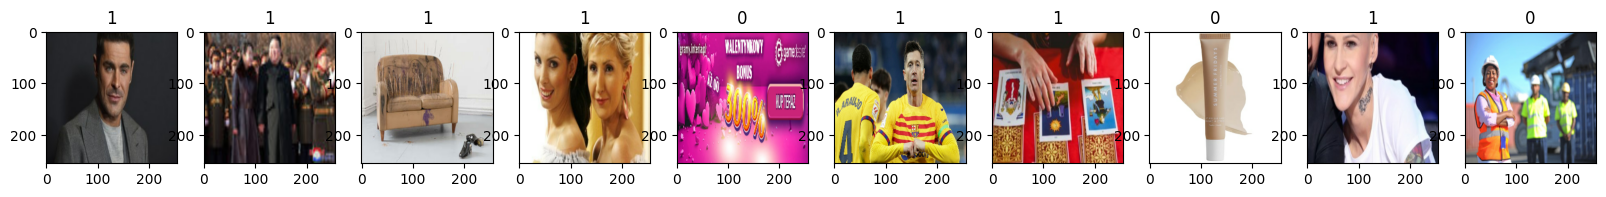

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20)) # class 1= simple image, class 0 = Ad
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

From the above plot, we see how the function assigns the classes (this may change from run-to-run):

simple image = 1 <br>
Ad = 0

## Preprocess data

In [ ]:
print(batch[0].max()) # our pixels are between values 0 and 255. we will scale them to be between 0 and 1

255.0


In [ ]:
#batch[0] / 255

In [ ]:
scaled= data.map(lambda x,y: (x/255, y)) # as we load a batch from the pipeline, we scale them on the go

In [ ]:
#scaled.as_numpy_iterator().next()

In [ ]:
scaled_iterator=scaled.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
batch[0].max()

1.0

In [ ]:
#scaled.as_numpy_iterator().next()

# Split Data

In [ ]:
#len(scaled)
len(data)

44

In [ ]:
train_size = int(len(scaled)*.7)# batch size 8, 156 batches, 32, 41 batches
val_size = int(len(scaled)*.2) # 44 batces
test_size = int(len(scaled)*.1) # 22 batches
#test_size = int(len(scaledtest)) # 22 batches

In [ ]:
print(f'Train Size: {train_size}, Val Size:{val_size}, Test Size: {test_size}')


Train Size: 30, Val Size:8, Test Size: 4


In [ ]:
train = scaled.take(train_size)
val = scaled.skip(train_size).take(val_size)
test = scaled.skip(train_size+val_size).take(test_size)

In [ ]:
#train.as_numpy_iterator().next()[0]

array([[[[0.8806372 , 0.70526963, 0.81844366],
         [0.89577204, 0.7387255 , 0.84522057],
         [0.89528185, 0.7706495 , 0.8670956 ],
         ...,
         [0.5074755 , 0.40784314, 0.54626226],
         [0.46568626, 0.36930147, 0.5172794 ],
         [0.3954044 , 0.30747548, 0.45704657]],

        [[0.88521755, 0.711818  , 0.8207338 ],
         [0.9013185 , 0.7423396 , 0.84654456],
         [0.90215224, 0.7729396 , 0.8670956 ],
         ...,
         [0.50296676, 0.40036443, 0.53488314],
         [0.4411031 , 0.34410998, 0.48714983],
         [0.40334833, 0.31180528, 0.45647404]],

        [[0.8908854 , 0.716652  , 0.8211627 ],
         [0.90818197, 0.74611676, 0.8467925 ],
         [0.9106541 , 0.7749281 , 0.8662501 ],
         ...,
         [0.50599295, 0.39922675, 0.52856195],
         [0.42417315, 0.32415375, 0.461966  ],
         [0.38749367, 0.29080188, 0.43077585]],

        ...,

        [[0.8786005 , 0.9531103 , 0.84330636],
         [0.8812883 , 0.9557981 , 0.8459942 ]

In [ ]:
#batch[0]

In [ ]:
len(train)

30

# Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten ,Dropout, BatchNormalization

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('rmsprop', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                        

# Train

In [ ]:
hist = model.fit(train, epochs=30, validation_data=val)

Epoch 1/40
30/30 [==============================] - 34s 408ms/step - loss: 1.2022 - accuracy: 0.7615 - val_loss: 0.7016 - val_accuracy: 0.7734
Epoch 2/40
30/30 [==============================] - 13s 412ms/step - loss: 0.4068 - accuracy: 0.8542 - val_loss: 0.8527 - val_accuracy: 0.7422
Epoch 3/40
30/30 [==============================] - 13s 419ms/step - loss: 0.3445 - accuracy: 0.8896 - val_loss: 0.8179 - val_accuracy: 0.7695
Epoch 4/40
30/30 [==============================] - 27s 889ms/step - loss: 0.2744 - accuracy: 0.9031 - val_loss: 1.1102 - val_accuracy: 0.7734
Epoch 5/40
30/30 [==============================] - 16s 468ms/step - loss: 0.2405 - accuracy: 0.9167 - val_loss: 0.6199 - val_accuracy: 0.7617
Epoch 6/40
30/30 [==============================] - 13s 413ms/step - loss: 0.1782 - accuracy: 0.9427 - val_loss: 0.7412 - val_accuracy: 0.7734
Epoch 7/40
30/30 [==============================] - 13s 415ms/step - loss: 0.1703 - accuracy: 0.9427 - val_loss: 0.7633 - val_accuracy: 0.7773

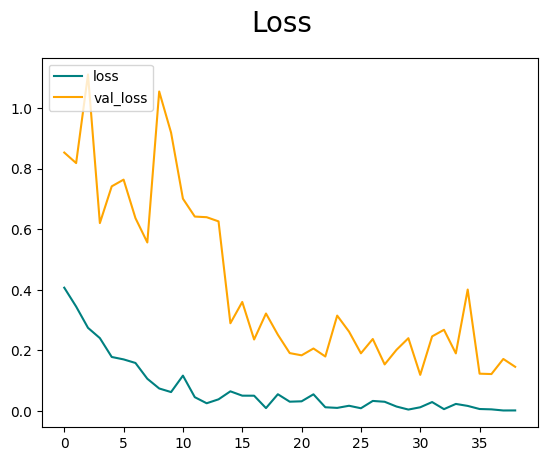

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'][1:], color='teal', label='loss')
plt.plot(hist.history['val_loss'][1:], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

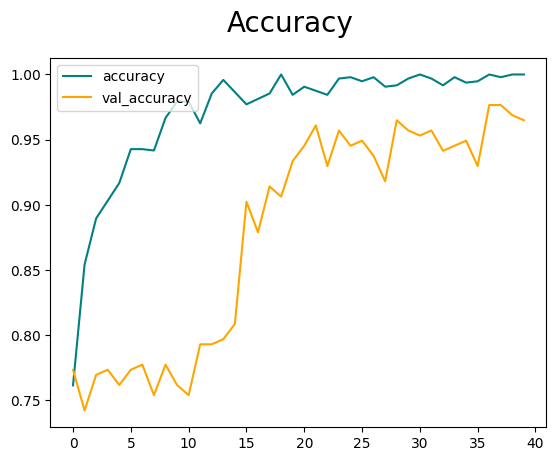

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [ ]:

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

1/1 [==============================] - 0s 168ms/step
Precision: 0.9166666865348816, Recall:1.0, Accuracy: 0.9375
1/1 [==============================] - 0s 29ms/step
Precision: 0.9599999785423279, Recall:0.9795918464660645, Accuracy: 0.953125
1/1 [==============================] - 0s 41ms/step
Precision: 0.9594594836235046, Recall:0.9861111044883728, Accuracy: 0.9583333134651184
1/1 [==============================] - 0s 40ms/step
Precision: 0.96875, Recall:0.96875, Accuracy: 0.953125


# Extra Testing on Unseen Data

In [ ]:
import cv2

In [ ]:
Current_dir = os.getcwd()
Current_dir

'/content/drive/MyDrive/Colab Notebooks/Thesis/data'

In [ ]:
#img = cv2.imread('sim.jpg')
#img= cv2.imread(os.path.join('testData','4.png')) # s (246).jpg, 9.png, 4.png, s (481).jpg
img= cv2.imread(os.path.join('unseen data','folder_5_main_12.jpg')) # futurama.jpeg, homer-simpson-wallpaper-preview.jpg , zoid.jpeg, bart-simpson-.jpg, fry.jpeg, homer-simpson-the-simpsons-.jpg, marg.jpg
img

In [ ]:
len(img)


TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
#plt.imshow(resize.numpy().astype(int))
#plt.show()

In [ ]:
resize.shape

In [ ]:
np.expand_dims(resize,0).shape

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

In [ ]:
#class 1= futurama, class 0 = simpsons

if yhat < 0.5:
    print(f'Predicted Simple Image')
else:
    print(f'Predicted Ad')

# Saving the model

In [ ]:
from keras.models import load_model

In [ ]:
#model.save(os.path.join('models','ad_classifier_first.h5'))
model.summary()

# Appling a Pre-trained CNN on our Dataset for comparison

The VGG16 model

In [ ]:
#from keras.applications import VGG16

#conv_base = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(256, 256, 3))

In [ ]:
#conv_base.summary()


We will add a dense layer after our conv_base NN

In [ ]:
# from keras import models
# from keras import layers

# modelPreT = models.Sequential()
# modelPreT.add(conv_base)

# modelPreT.add(layers.Flatten())
# modelPreT.add(layers.Dense(256, activation='relu'))
# modelPreT.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#modelPreT.summary()

Before training the model, we need to separate the pretrained model from our DNN which is added on top of that. So that when we train our model we dont ruin the pretrained weights and biased of the VGG16

In [ ]:
#print('This is the number of trainable weights '
#      'before freezing the conv base:', len(modelPreT.trainable_weights))

In [ ]:
#conv_base.trainable = False

In [ ]:
#print('This is the number of trainable weights '
 #     'after freezing the conv base:', len(modelPreT.trainable_weights))

In [ ]:
#modelPreT.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
#train.as_numpy_iterator().next()[0]

In [ ]:
#histPreT = modelPreT.fit(train, epochs=4, validation_data=val) #  epochs 10 are over fitting. early stop at?

In [ ]:
# acc = histPreT.history['accuracy']
# val_acc = histPreT.history['val_accuracy']
# loss = histPreT.history['loss']
# val_loss = histPreT.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [ ]:
# pre = Precision()
# re = Recall()
# acc = BinaryAccuracy()

In [ ]:
# for batch in test.as_numpy_iterator():
#     X, y = batch
#     yhatPreT = modelPreT.predict(X)
#     pre.update_state(y, yhatPreT)
#     re.update_state(y, yhatPreT)
#     acc.update_state(y, yhatPreT)
#     print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

In [ ]:
#imgPre= cv2.imread(os.path.join('testData','Unseen','futurama1.jpg')) # marg.jpg, homer-simpson-the-simpsons-.jpg, 4.png, s (481).jpg , images.jpg, bender.jpeg, fry.jpeg
#imgPre= cv2.imread(os.path.join('testData','s (481).jpg')) # marg.jpg, homer-simpson-the-simpsons-.jpg, 4.png, s (481).jpg , images.jpg, bender.jpeg, fry.jpeg

In [ ]:
#plt.imshow(cv2.cvtColor(imgPre, cv2.COLOR_BGR2RGB))
#plt.show()

In [ ]:
#resizePreT = tf.image.resize(imgPre, (256,256))
#resize

In [ ]:
#plt.imshow(resizePreT.numpy().astype(int))
#plt.show()

In [ ]:
#np.expand_dims(resizePreT,0).shape

In [ ]:
#yhat_newPreT = modelPreT.predict(np.expand_dims(resizePreT/255, 0))#/255 scale
#yhat_newPreT

For the pretrained model the classes were inverted, so we have:

Simpsons = 0 <br>
Futurama = 1

In [ ]:
#class 0= futurama, class 1 = simpsons

# if yhat_newPreT < 0.5:
#     print(f'Predicted class is simpsons')
# else:
#     print(f'Predicted class is futurama')

In [ ]:
#modelPreT.save(os.path.join('models','Pretrained_futurama_and_simpsons.h5'))
#modelPreT.summary()  # As a reminder.